# Album Art Image Similarity

In this notebook, we aim to analyse the image similarity in album art images by extracting features from the images using a pretrained CV network provided by tensorflow. Then we use dimentionality reduction and clustering to find out the feature extractor thinks are similar images

In [45]:
import gc
import numpy as np
import os
from multiprocessing import Pool, cpu_count
import gc
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


# Define functions to extract features from images, dimentionality reduction, Clustering and Cluster Visualization

In [46]:
def extract_features(image_data):
    """
    Extracts features from image data using the EfficientNetB3 model pre-trained on ImageNet.

    Parameters:
    image_data (numpy array): Array of images with shape (num_images, 220, 220, 3).

    Returns:
    numpy array: Flattened features with shape (num_images, num_features).
    """
    
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(220,220,3))
    features = base_model.predict(image_data, verbose=1, batch_size=16)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

def reduce_dimensionality(features, n_components=50):
    """
    Reduces the dimensionality of the features using PCA.

    Parameters:
    features (numpy array): Array of extracted features with shape (num_images, num_features).
    n_components (int): Number of principal components to keep. Default is 50.

    Returns:
    numpy array: Features transformed to the lower dimensional space.
    """
    
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    return features_pca

def cluster_images(features, num_clusters):
    """
    Clusters the images based on their features using KMeans.

    Parameters:
    features (numpy array): Array of features with shape (num_images, num_features).
    num_clusters (int): Number of clusters to form.

    Returns:
    tuple: KMeans model and cluster labels for each image.
    """
    
    kmeans = KMeans(n_clusters=num_clusters, n_init=20, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    return kmeans, cluster_labels

def visualize_cluster_images(images, labels, cluster_label, grid_size=(4, 4)):
    """
    Visualizes images that belong to a specified cluster.

    Parameters:
    images (list of numpy arrays): List of images.
    labels (numpy array): Array of cluster labels for each image.
    cluster_label (int): The cluster label to visualize.
    grid_size (tuple): The size of the grid to display the images in (rows, cols). Default is (4, 4).

    Returns:
    None
    """
    # Filter images by the specified cluster label
    filtered_images = [image for image, label in zip(images, labels) if label == cluster_label]
    
    # Select a subset of filtered images to fit into the grid
    num_images_to_show = grid_size[0] * grid_size[1]
    filtered_images = filtered_images[:num_images_to_show]
    
    # Create a figure for the subplots
    plt.figure(figsize=(15, 15))
    
    for i, image in enumerate(filtered_images):
        image = image / 255.0  # Normalize the image
        plt.subplot(grid_size[0], grid_size[1], i + 1)  # Add a subplot at the correct position
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
    
    # Add a single title for the entire figure
    plt.suptitle(f"Images with cluster label as {cluster_label}", fontsize=10)
    
    # Display all subplots together
    plt.tight_layout()
    plt.show()

# Read the images as NumPy array from disk

Although the images are stored in jpg in the `images` folder, they need to be preprocessed in order for them to go through the feature extraction process from the `EfficientNetB3` model. This preprocessing is done in a separate file named `preprocess.py` that can be found in the working directory

In [4]:
images = np.load("preprocessed_features.npz", allow_pickle=True).get("arr_0")

In [5]:
num_samples = images.shape[0] // 4

# Generate random indices
random_indices = np.random.choice(images.shape[0], num_samples, replace=False)

# Sample the data using the random indices
sampled_data = images[random_indices]

In [7]:
del images
gc.collect(0)
gc.collect(1)
gc.collect(2)

264

Since we are using a subset of the images available (due to memory limitations), the `gc` module is used for memory cleanup.

# Feature extraction using the `EfficientNetB3` Model and Clustering 

In [12]:
features = extract_features(sampled_data)

233/233 [==============================] - 66s 254ms/step


In [14]:
features = reduce_dimensionality(features, n_components=100)

In [48]:
kmeans_model, cluster_labels = cluster_images(features, num_clusters=20)

# Visualizing the Cluster Similarity in a 2D Space

- After performing K-Means clustering, we visualize the euclidean distance between these centroids to visualize which clusters lie close to each other in a 2D space. This will help us later to visually understand which images are grouped in the same cluster and which two clusters are close to each other, indicating feature similarity between images that lie in two different clusters, but have very similar "semantic" meaning.
- Euclidean distance can be calculated by: $$d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}
$$

In [51]:
centroids = kmeans_model.cluster_centers_

distances = cdist(centroids, centroids, metric='euclidean')

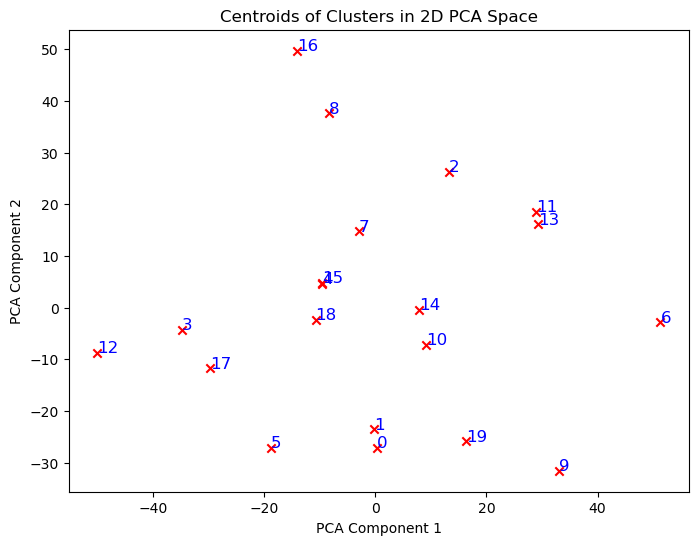

In [53]:
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='x')

for i, txt in enumerate(range(len(centroids_2d))):
    plt.annotate(txt, (centroids_2d[i, 0], centroids_2d[i, 1]), fontsize=12, color='blue')
plt.title('Centroids of Clusters in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Visualize all images belonging to a particular cluster

In [61]:
visualize_cluster_images(sampled_data, cluster_labels, cluster_label=9)

In [62]:
visualize_cluster_images(sampled_data, cluster_labels, cluster_label=16)

# Thank You!